# PCA-Based Visualization of Mel Spectrogram Features

This notebook demonstrates how to:
- Extract mel spectrogram features using the AFX library
- Apply PCA (provided by AFX) to reduce the dimensionality of the features
- Visualize PCA results to explore class separability and patterns in feature space

## Goals

- Evaluate if ESC-50 is linearly separable
- Quantitatively assess how well PCA can separate ESC-50 classes
- Identify overlapping classes or clusters
- Evaluate the number of PCA components that explain most variance
- Compare different aggregation strategies (mean, std, stack)

## Prerequisites

Before running this notebook, ensure that:
1. The ESC-50 dataset is downloaded and extracted
2. The `ESC_50_dataset` environment variable points to the dataset root directory

## Setup and Imports

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# AFX imports
from AFX.io.io import load_audio
from AFX.utils.config_loader import load_config
from AFX.extract_all import extract_all_features
from AFX.utils.aggregator import aggregate_features
from AFX.utils.selectors import pca_reducer
from AFX.utils.visualization import plot_spectrogram

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All imports successful")

✓ All imports successful


## Dataset Setup and Verification

In [2]:
# Load dataset paths from environment
DATASET_PATH = os.getenv('ESC_50_dataset')
if DATASET_PATH is None:
    DATASET_PATH = '../data/ESC-50-master'  # Fallback path

audio_path = os.path.join(DATASET_PATH, 'audio')
metadata_path = os.path.join(DATASET_PATH, 'meta', 'esc50.csv')
config_path = os.path.join('config.json')

# Verify dataset structure
print("Dataset structure verification:")
print(f"Audio path: {audio_path} - {'✓ exists' if os.path.exists(audio_path) else '❌ missing'}")
print(f"Metadata file: {metadata_path} - {'✓ exists' if os.path.exists(metadata_path) else '❌ missing'}")
print(f"Config file: {config_path} - {'✓ exists' if os.path.exists(config_path) else '❌ missing'}")

if not all([os.path.exists(audio_path), os.path.exists(metadata_path), os.path.exists(config_path)]):
    print("\n❌ Dataset structure verification failed!")
    print("Please ensure the ESC-50 dataset is properly extracted and the path is correct.")
else:
    print("\n✓ Dataset structure verification passed!")

Dataset structure verification:
Audio path: D:\datasets\ESC-50-master\audio - ✓ exists
Metadata file: D:\datasets\ESC-50-master\meta\esc50.csv - ✓ exists
Config file: config.json - ✓ exists

✓ Dataset structure verification passed!


## Load and Explore Metadata

In [3]:
# Load ESC-50 metadata
try:
    metadata = pd.read_csv(metadata_path)
    print(f"✓ Loaded metadata: {len(metadata)} audio files")
    print(f"✓ Unique categories: {metadata['category'].nunique()}")
    print(f"✓ Files per category: {len(metadata) // metadata['category'].nunique()}")
    
    # Display class distribution
    class_counts = metadata['category'].value_counts()
    print(f"\nClass distribution (first 10):")
    print(class_counts.head(10))
    
except Exception as e:
    print(f"❌ Error loading metadata: {e}")
    sys.exit(1)

✓ Loaded metadata: 2000 audio files
✓ Unique categories: 50
✓ Files per category: 40

Class distribution (first 10):
category
dog                40
chirping_birds     40
vacuum_cleaner     40
thunderstorm       40
door_wood_knock    40
can_opening        40
crow               40
clapping           40
fireworks          40
chainsaw           40
Name: count, dtype: int64


## Sample Selection for Analysis

For computational efficiency, we'll work with a subset of the data that includes representative samples from each class.

In [4]:
# Select a subset for analysis (adjust sample size based on computational resources)
SAMPLES_PER_CLASS = 40  # Increase/decrease this for your analysis
MAX_CLASSES = 10       # Limit number of classes for initial visualization

# Get most common classes for analysis
top_classes = metadata['category'].value_counts().head(MAX_CLASSES).index.tolist()
print(f"Selected classes for analysis: {top_classes}")

# Sample data for each class
sampled_data = []
for category in top_classes:
    class_data = metadata[metadata['category'] == category].sample(
        min(SAMPLES_PER_CLASS, len(metadata[metadata['category'] == category])), 
        random_state=42
    )
    sampled_data.append(class_data)

# Combine sampled data
sample_metadata = pd.concat(sampled_data, ignore_index=True)
print(f"\n✓ Selected {len(sample_metadata)} samples from {len(top_classes)} classes")
print(f"Distribution: {sample_metadata['category'].value_counts().to_dict()}")

Selected classes for analysis: ['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw']

✓ Selected 400 samples from 10 classes
Distribution: {'dog': 40, 'chirping_birds': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40}


## Configuration Setup for Mel Spectrogram Extraction

In [5]:
# Load AFX configuration
config = load_config(config_path)
print(f"✓ Loaded configuration from {config_path}")
print(f"Sample rate: {config['sample_rate']} Hz")

# Create mel spectrogram-specific configuration (doing it explecitly here)
mel_config = {
    'sample_rate': config['sample_rate'],
    'features': {
        'melspectrogram': config['features']['melspectrogram']
    },
    'aggregation': 'mean',
    'preserve_shape': True  # Keep original shape for aggregation experiments
}

print(f"\nMel spectrogram parameters:")
for key, value in mel_config['features']['melspectrogram'].items():
    print(f"  {key}: {value}")

✓ Loaded configuration from config.json
Sample rate: 22050 Hz

Mel spectrogram parameters:
  n_mels: 128
  frame_size: 2048
  hop_length: 512


## Mel Spectrogram Feature Extraction

Extract mel spectrogram features from all selected audio samples.

In [6]:
# Extract features for all samples
features_data = []
labels = []
failed_files = []

print("Extracting mel spectrogram features...")
for idx, row in tqdm(sample_metadata.iterrows(), total=len(sample_metadata)):
    try:
        # Load audio file
        audio_file = os.path.join(audio_path, row['filename'])
        signal, sr = load_audio(audio_file, sr=mel_config['sample_rate'])
        
        # Extract mel spectrogram features
        features = extract_all_features(signal, sr, mel_config)
        
        # Store results
        features_data.append(features['melspectrogram'])
        labels.append(row['category'])
        
    except Exception as e:
        print(f"Failed to process {row['filename']}: {e}")
        failed_files.append(row['filename'])

print(f"\n✓ Successfully extracted features from {len(features_data)} files")
if len(failed_files) > 0:
    print(f"❌ Failed to process {len(failed_files)} files")

if features_data:
    print(f"✓ Mel spectrogram shape per file: {features_data[0].shape}")
    print(f"  - Mel bins: {features_data[0].shape[0]}")
    print(f"  - Time frames: {features_data[0].shape[1]}")

Extracting mel spectrogram features...


100%|██████████| 400/400 [00:24<00:00, 16.27it/s]


✓ Successfully extracted features from 400 files
✓ Mel spectrogram shape per file: (128, 216)
  - Mel bins: 128
  - Time frames: 216


## Feature Aggregation Strategies

Compare different methods for aggregating mel spectrogram features over time.

In [7]:
def aggregate_mel_features(features_list, method='mean'):
    """Aggregate a list of mel spectrogram features using specified method."""
    aggregated = []
    
    for mel_spec in features_list:
        # Create feature dict for aggregation function
        feature_dict = {'melspectrogram': mel_spec}
        
        # Apply aggregation
        agg_features = aggregate_features(feature_dict, method=method, flatten=True)
        
        if method == 'stack':
            # For stack method, the result is a numpy array
            aggregated.append(agg_features)
        elif method == 'summary':
            # For summary method, concatenate mean and std features
            mean_feat = agg_features['melspectrogram_mean']
            std_feat = agg_features['melspectrogram_std']
            combined = np.concatenate([mean_feat, std_feat])
            aggregated.append(combined)
        else:
            # For other methods, extract the melspectrogram key
            aggregated.append(agg_features['melspectrogram'])
    
    return np.array(aggregated)

# Test different aggregation methods
aggregation_methods = ['mean', 'std', 'summary']
aggregated_features = {}

for method in aggregation_methods:
    print(f"\nAggregating features using '{method}' method...")
    agg_data = aggregate_mel_features(features_data, method=method)
    aggregated_features[method] = agg_data
    print(f"✓ Aggregated shape: {agg_data.shape}")
    print(f"  - Samples: {agg_data.shape[0]}")
    print(f"  - Features per sample: {agg_data.shape[1]}")

# Also try stack method (flattened mel spectrograms)
print(f"\nAggregating features using 'stack' method...")
stack_data = aggregate_mel_features(features_data, method='stack')
aggregated_features['stack'] = stack_data
print(f"✓ Stacked shape: {stack_data.shape}")


Aggregating features using 'mean' method...
✓ Aggregated shape: (400, 128)
  - Samples: 400
  - Features per sample: 128

Aggregating features using 'std' method...
✓ Aggregated shape: (400, 128)
  - Samples: 400
  - Features per sample: 128

Aggregating features using 'summary' method...
✓ Aggregated shape: (400, 256)
  - Samples: 400
  - Features per sample: 256

Aggregating features using 'stack' method...
✓ Stacked shape: (400, 27648)


## PCA Analysis

Apply PCA to the aggregated features and analyze the results.

In [8]:
def apply_pca_analysis(features, labels, method_name, n_components=10):
    """Apply PCA analysis to features and return results."""
    print(f"\n=== PCA Analysis for {method_name} aggregation ===")
    
    # Prepare features for PCA
    if features.ndim == 1:
        # Handle case where we have a 1D array (shouldn't happen but good to check)
        features = features.reshape(1, -1)
    
    # Create feature dictionary for pca_reducer
    feature_dict = {'features': features.T}  # Transpose to get (features, samples)
    
    # Apply PCA
    pca_result, pca_model = pca_reducer(feature_dict, n_components=n_components)
    
    print(f"✓ PCA applied: {features.shape} -> {pca_result.shape}")
    print(f"✓ Explained variance ratio (top 5): {pca_model.explained_variance_ratio_[:5]}")
    print(f"✓ Cumulative explained variance (top 5): {np.cumsum(pca_model.explained_variance_ratio_)[:5]}")
    
    return {
        'pca_result': pca_result,
        'pca_model': pca_model,
        'labels': labels,
        'method': method_name
    }

# Apply PCA to each aggregation method
pca_results = {}
for method_name, features in aggregated_features.items():
    try:
        result = apply_pca_analysis(features, labels, method_name, n_components=10)
        pca_results[method_name] = result
    except Exception as e:
        print(f"❌ PCA failed for {method_name}: {e}")

print(f"\n✓ PCA analysis completed for {len(pca_results)} aggregation methods")


=== PCA Analysis for mean aggregation ===
✓ PCA applied: (400, 128) -> (400, 10)
✓ Explained variance ratio (top 5): [0.63961038 0.11187935 0.10550722 0.03416661 0.02291359]
✓ Cumulative explained variance (top 5): [0.63961038 0.75148973 0.85699694 0.89116355 0.91407714]

=== PCA Analysis for std aggregation ===
✓ PCA applied: (400, 128) -> (400, 10)
✓ Explained variance ratio (top 5): [0.56912926 0.18179922 0.0529726  0.0391504  0.03228133]
✓ Cumulative explained variance (top 5): [0.56912926 0.75092848 0.80390109 0.84305149 0.87533282]

=== PCA Analysis for summary aggregation ===
✓ PCA applied: (400, 256) -> (400, 10)
✓ Explained variance ratio (top 5): [0.58667592 0.15222792 0.04773484 0.03567177 0.03160402]
✓ Cumulative explained variance (top 5): [0.58667592 0.73890384 0.78663868 0.82231045 0.85391447]

=== PCA Analysis for stack aggregation ===
✓ PCA applied: (400, 27648) -> (400, 10)
✓ Explained variance ratio (top 5): [0.33821941 0.1322411  0.12223856 0.05961712 0.0461478 ]
✓

In [9]:
# --- Baseline (no PCA) for class separability analysis ---
# For each aggregation method, use the original features as a baseline
baseline_results = {}
for method_name, features in aggregated_features.items():
    try:
        print(f"\n=== Baseline (No PCA) Analysis for {method_name} aggregation ===")
        # Use the original features (no PCA)
        baseline_results[method_name] = {
            'pca_result': features,  # Not actually PCA, but for compatibility
            'labels': labels,
            'method': method_name,
            'pca_model': None  # No PCA model
        }
        print(f"✓ Baseline features shape: {features.shape}")
    except Exception as e:
        print(f"❌ Baseline analysis failed for {method_name}: {e}")

# Add baseline to pca_results for downstream analysis
for method_name, result in baseline_results.items():
    pca_results[f'{method_name}_baseline'] = result



=== Baseline (No PCA) Analysis for mean aggregation ===
✓ Baseline features shape: (400, 128)

=== Baseline (No PCA) Analysis for std aggregation ===
✓ Baseline features shape: (400, 128)

=== Baseline (No PCA) Analysis for summary aggregation ===
✓ Baseline features shape: (400, 256)

=== Baseline (No PCA) Analysis for stack aggregation ===
✓ Baseline features shape: (400, 27648)


## Explained Variance Analysis

Analyze how much variance is explained by different numbers of PCA components.

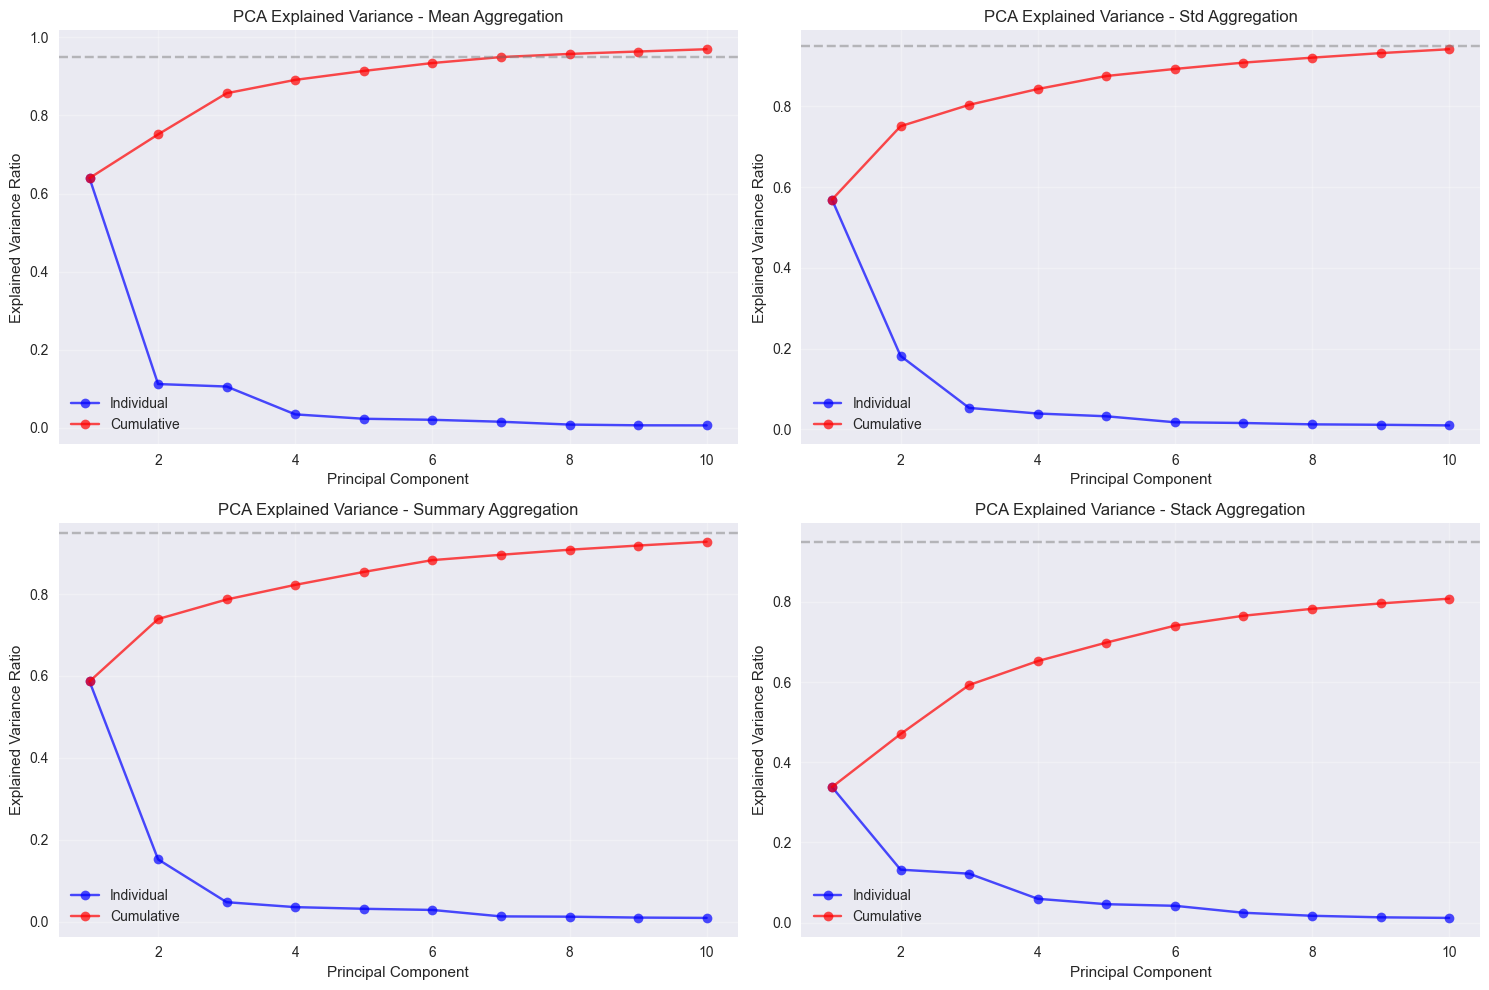


=== Explained Variance Summary ===

MEAN aggregation:
  - First 2 components explain: 0.751 of variance
  - First 3 components explain: 0.857 of variance
  - Components needed for 90% variance: 5
  - Components needed for 95% variance: 8

STD aggregation:
  - First 2 components explain: 0.751 of variance
  - First 3 components explain: 0.804 of variance
  - Components needed for 90% variance: 7
  - Components needed for 95% variance: 1

SUMMARY aggregation:
  - First 2 components explain: 0.739 of variance
  - First 3 components explain: 0.787 of variance
  - Components needed for 90% variance: 8
  - Components needed for 95% variance: 1

STACK aggregation:
  - First 2 components explain: 0.470 of variance
  - First 3 components explain: 0.593 of variance
  - Components needed for 90% variance: 1
  - Components needed for 95% variance: 1


In [10]:
# Plot explained variance for each aggregation method
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

plot_idx = 0
for method_name, result in pca_results.items():
    pca_model = result['pca_model']
    if pca_model is None:
        continue  # Skip baseline (no PCA) results
    if plot_idx >= 4:  # Only plot first 4 methods
        break
    
    # Plot explained variance ratio
    axes[plot_idx].plot(range(1, len(pca_model.explained_variance_ratio_) + 1),
                   pca_model.explained_variance_ratio_, 
                   'bo-', label='Individual', alpha=0.7)
    
    # Plot cumulative explained variance
    axes[plot_idx].plot(range(1, len(pca_model.explained_variance_ratio_) + 1),
                   np.cumsum(pca_model.explained_variance_ratio_), 
                   'ro-', label='Cumulative', alpha=0.7)
    
    axes[plot_idx].set_xlabel('Principal Component')
    axes[plot_idx].set_ylabel('Explained Variance Ratio')
    axes[plot_idx].set_title(f'PCA Explained Variance - {method_name.title()} Aggregation')
    axes[plot_idx].legend()
    axes[plot_idx].grid(True, alpha=0.3)
    
    # Add 95% variance line
    axes[plot_idx].axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='95% Variance')
    plot_idx += 1

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Explained Variance Summary ===")
for method_name, result in pca_results.items():
    pca_model = result['pca_model']
    if pca_model is None:
        continue  # Skip baseline (no PCA) results
    var_95_components = np.argmax(np.cumsum(pca_model.explained_variance_ratio_) >= 0.95) + 1
    var_90_components = np.argmax(np.cumsum(pca_model.explained_variance_ratio_) >= 0.90) + 1
    
    print(f"\n{method_name.upper()} aggregation:")
    print(f"  - First 2 components explain: {np.sum(pca_model.explained_variance_ratio_[:2]):.3f} of variance")
    print(f"  - First 3 components explain: {np.sum(pca_model.explained_variance_ratio_[:3]):.3f} of variance")
    print(f"  - Components needed for 90% variance: {var_90_components}")
    print(f"  - Components needed for 95% variance: {var_95_components}")

## 2D PCA Visualization

Visualize the first two principal components with class labels.

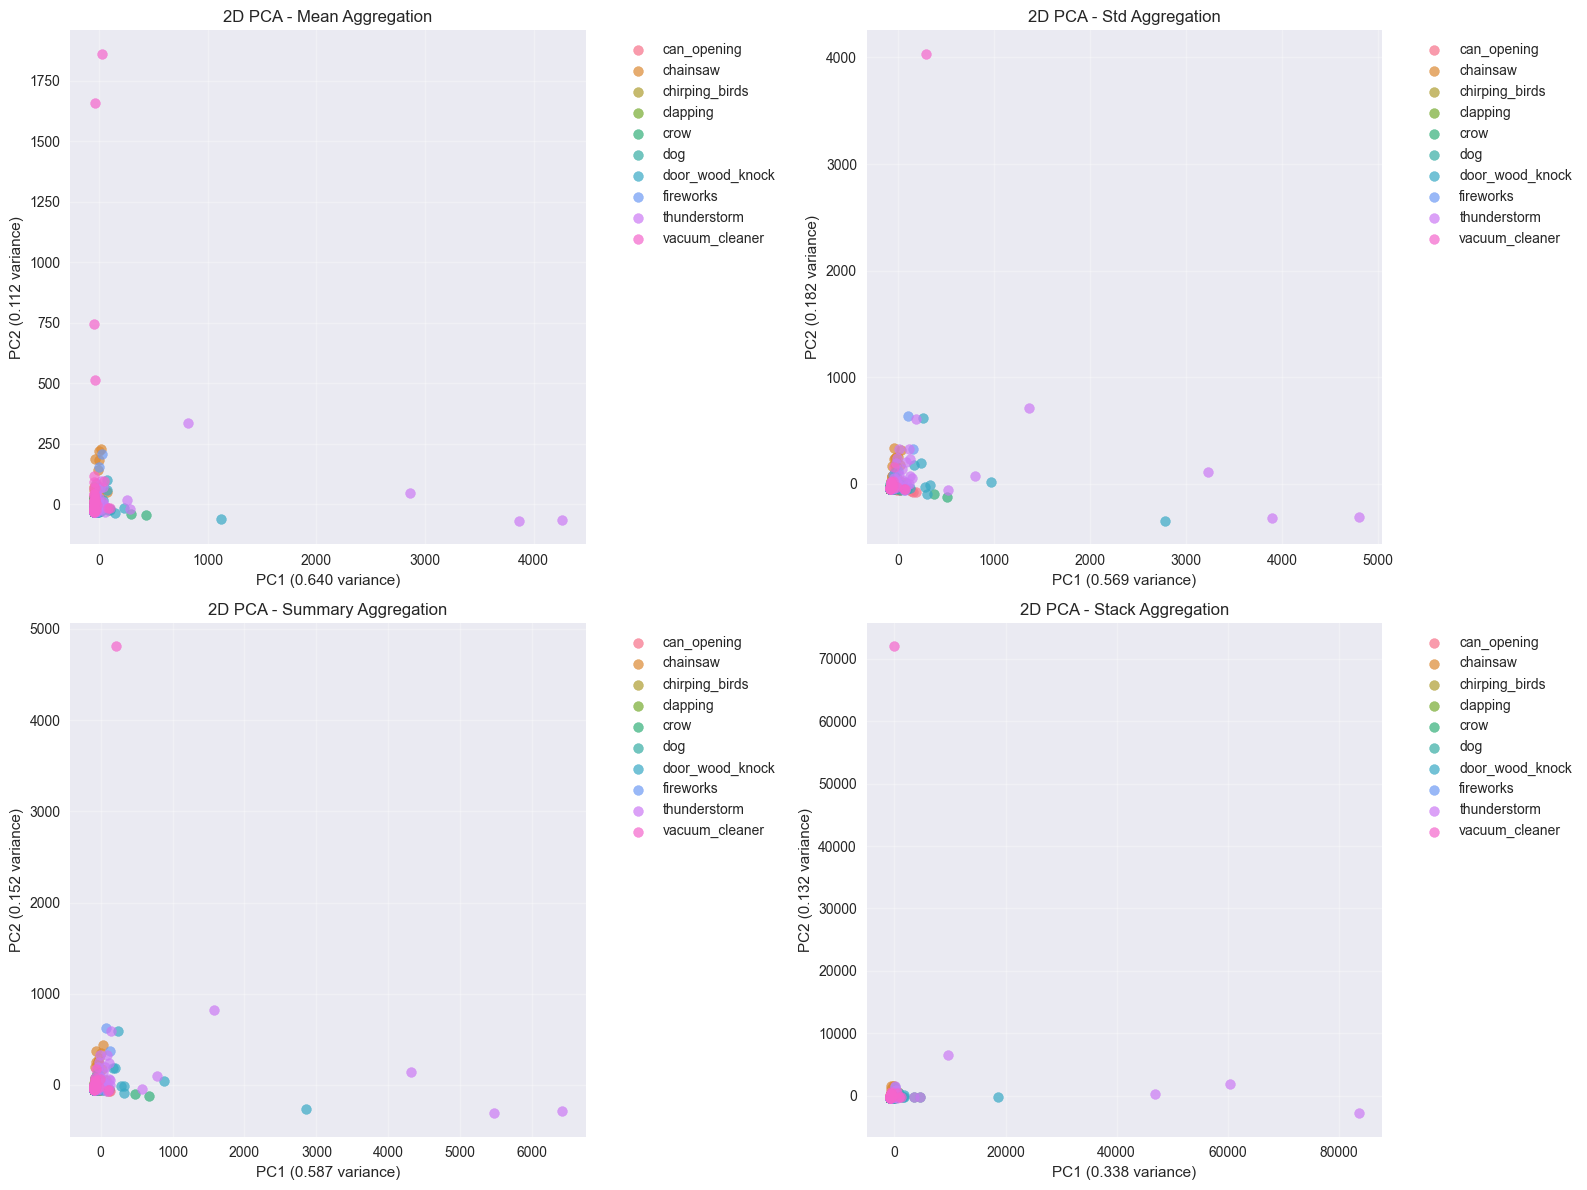

In [11]:
# Create 2D scatter plots for each aggregation method
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Get unique classes and colors
unique_classes = sorted(list(set(labels)))
colors = sns.color_palette("husl", len(unique_classes))
class_color_map = dict(zip(unique_classes, colors))

for idx, (method_name, result) in enumerate(pca_results.items()):
    if idx >= 4:  # Only plot first 4 methods
        break
        
    pca_data = result['pca_result']
    method_labels = result['labels']
    
    # Plot each class
    for class_name in unique_classes:
        class_mask = np.array(method_labels) == class_name
        axes[idx].scatter(pca_data[class_mask, 0], pca_data[class_mask, 1], 
                         c=[class_color_map[class_name]], 
                         label=class_name, alpha=0.7, s=50)
    
    axes[idx].set_xlabel(f'PC1 ({result["pca_model"].explained_variance_ratio_[0]:.3f} variance)')
    axes[idx].set_ylabel(f'PC2 ({result["pca_model"].explained_variance_ratio_[1]:.3f} variance)')
    axes[idx].set_title(f'2D PCA - {method_name.title()} Aggregation')
    axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3D PCA Visualization

Visualize the first three principal components for better class separation analysis.

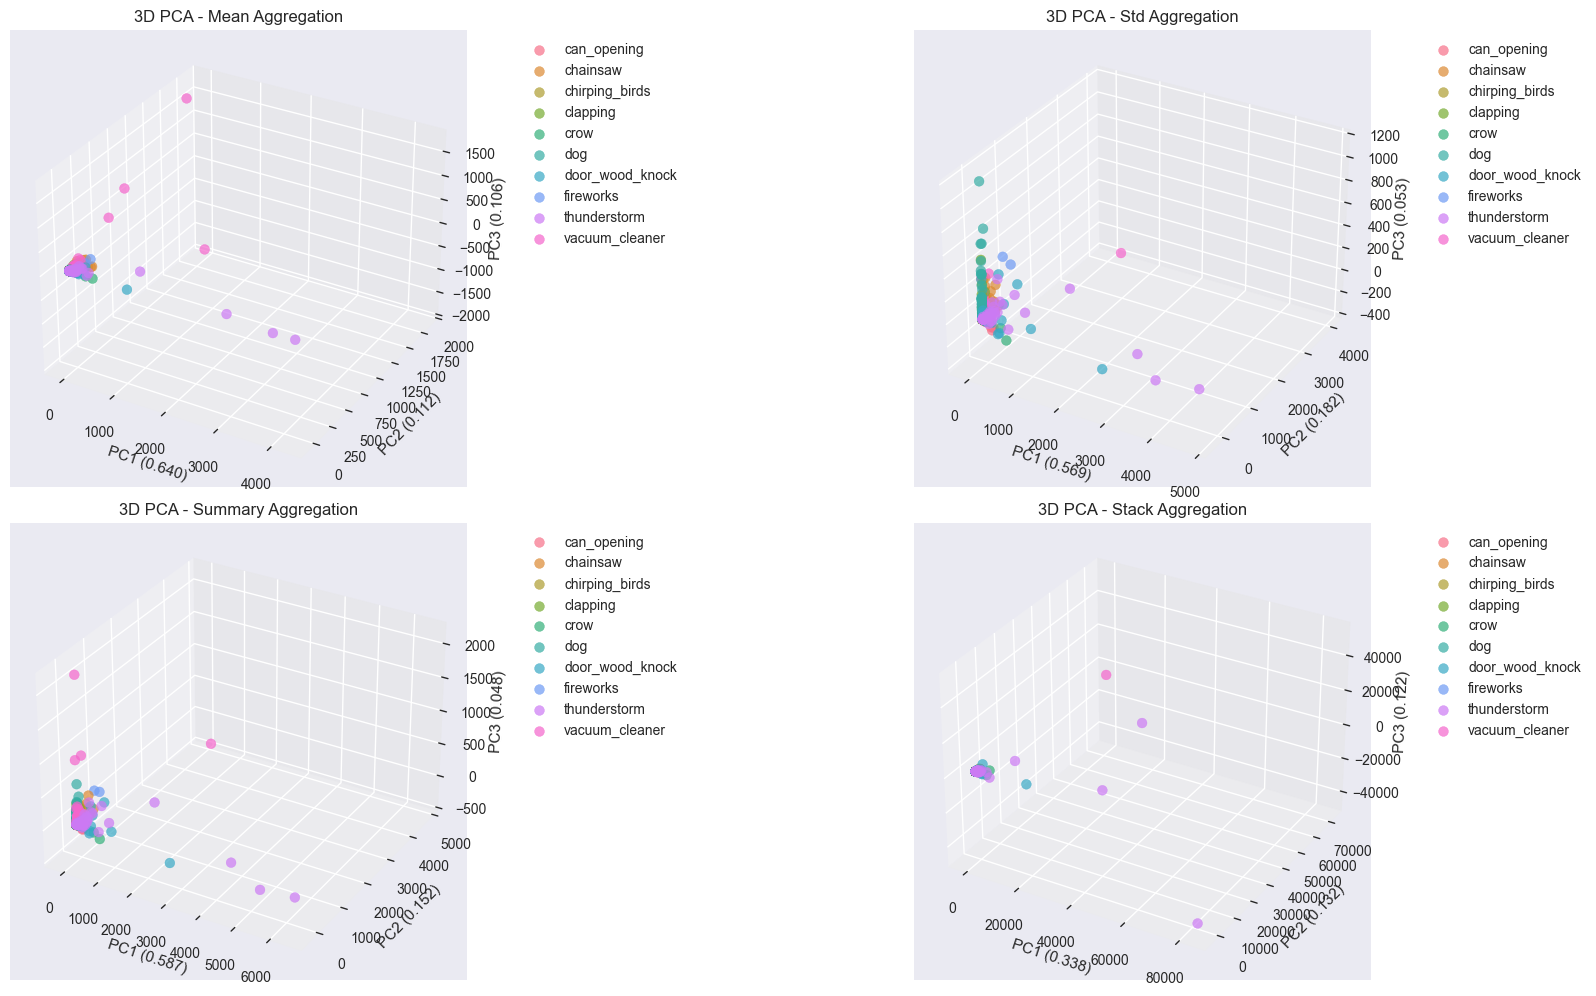

In [12]:
# Create 3D scatter plots
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))

subplot_idx = 1
for method_name, result in pca_results.items():
    if subplot_idx > 4:  # Only plot first 4 methods
        break
        
    ax = fig.add_subplot(2, 2, subplot_idx, projection='3d')
    
    pca_data = result['pca_result']
    method_labels = result['labels']
    pca_model = result['pca_model']
    
    # Plot each class
    for class_name in unique_classes:
        class_mask = np.array(method_labels) == class_name
        ax.scatter(pca_data[class_mask, 0], 
                  pca_data[class_mask, 1], 
                  pca_data[class_mask, 2],
                  c=[class_color_map[class_name]], 
                  label=class_name, alpha=0.7, s=50)
    
    ax.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.3f})')
    ax.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.3f})')
    ax.set_zlabel(f'PC3 ({pca_model.explained_variance_ratio_[2]:.3f})')
    ax.set_title(f'3D PCA - {method_name.title()} Aggregation')
    ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
    
    subplot_idx += 1

plt.tight_layout()
plt.show()

## Class Separability Analysis

Quantitative analysis of how well different aggregation methods separate classes in PCA space.

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

def analyze_class_separability(pca_data, labels, method_name, n_components=[2, 3, 5]):
    """Analyze class separability using various metrics."""
    print(f"\n=== Class Separability Analysis - {method_name.title()} ===")
    
    # Encode labels for sklearn metrics
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    results = {}
    
    for n_comp in n_components:
        if n_comp <= pca_data.shape[1]:
            # Use first n_comp components
            data_subset = pca_data[:, :n_comp]
            
            # Calculate silhouette score (higher is better, range [-1, 1])
            sil_score = silhouette_score(data_subset, encoded_labels)
            
            # Calculate within-class vs between-class distances
            within_class_distances = []
            between_class_distances = []
            
            for class_label in unique_classes:
                class_mask = np.array(labels) == class_label
                class_data = data_subset[class_mask]
                
                if len(class_data) > 1:
                    # Within-class distances (should be small)
                    class_center = np.mean(class_data, axis=0)
                    within_distances = np.linalg.norm(class_data - class_center, axis=1)
                    within_class_distances.extend(within_distances)
                    
                    # Between-class distances (should be large)
                    for other_class in unique_classes:
                        if other_class != class_label:
                            other_mask = np.array(labels) == other_class
                            other_data = data_subset[other_mask]
                            if len(other_data) > 0:
                                other_center = np.mean(other_data, axis=0)
                                between_distance = np.linalg.norm(class_center - other_center)
                                between_class_distances.append(between_distance)
            
            avg_within = np.mean(within_class_distances) if within_class_distances else 0
            avg_between = np.mean(between_class_distances) if between_class_distances else 0
            separation_ratio = avg_between / avg_within if avg_within > 0 else float('inf')
            
            results[n_comp] = {
                'silhouette_score': sil_score,
                'avg_within_distance': avg_within,
                'avg_between_distance': avg_between,
                'separation_ratio': separation_ratio
            }
            
            print(f"\n{n_comp} components:")
            print(f"  Silhouette Score: {sil_score:.4f}")
            print(f"  Avg Within-Class Distance: {avg_within:.4f}")
            print(f"  Avg Between-Class Distance: {avg_between:.4f}")
            print(f"  Separation Ratio: {separation_ratio:.4f}")
    
    return results

# Analyze separability for each method (including baseline)
separability_results = {}
for method_name, result in pca_results.items():
    # Determine n_full for this method (number of features)
    n_full = result['pca_result'].shape[1] if result['pca_result'] is not None else None
    # Use [2, 3, 5, n_full] if n_full is available and > 5
    n_comp_list = [2, 3, 5]
    if n_full is not None and n_full > 5:
        n_comp_list = [2, 3, 5, n_full]
    elif n_full is not None and n_full not in n_comp_list:
        n_comp_list.append(n_full)
    separability_results[method_name] = analyze_class_separability(
        result['pca_result'], result['labels'], method_name, n_components=n_comp_list
    )


=== Class Separability Analysis - Mean ===

2 components:
  Silhouette Score: -0.4450
  Avg Within-Class Distance: 99.4611
  Avg Between-Class Distance: 116.1732
  Separation Ratio: 1.1680

3 components:
  Silhouette Score: -0.4502
  Avg Within-Class Distance: 107.2424
  Avg Between-Class Distance: 118.6641
  Separation Ratio: 1.1065

5 components:
  Silhouette Score: -0.4596
  Avg Within-Class Distance: 123.0886
  Avg Between-Class Distance: 131.3516
  Separation Ratio: 1.0671

10 components:
  Silhouette Score: -0.4570
  Avg Within-Class Distance: 146.1807
  Avg Between-Class Distance: 143.0413
  Separation Ratio: 0.9785

=== Class Separability Analysis - Std ===

2 components:
  Silhouette Score: -0.4506
  Avg Within-Class Distance: 138.6441
  Avg Between-Class Distance: 156.1114
  Separation Ratio: 1.1260

3 components:
  Silhouette Score: -0.3909
  Avg Within-Class Distance: 169.7144
  Avg Between-Class Distance: 190.1404
  Separation Ratio: 1.1204

5 components:
  Silhouette Sco

## Comparative Analysis of Aggregation Methods


=== Method Comparison Summary ===
              Method  Components  Silhouette_Score  Separation_Ratio  \
0               mean           2           -0.4450            1.1680   
1               mean           3           -0.4502            1.1065   
2               mean           5           -0.4596            1.0671   
3               mean          10           -0.4570            0.9785   
4                std           2           -0.4506            1.1260   
5                std           3           -0.3909            1.1204   
6                std           5           -0.3966            1.0532   
7                std          10           -0.4054            0.9488   
8            summary           2           -0.4457            1.1383   
9            summary           3           -0.4131            1.0909   
10           summary           5           -0.4038            1.0448   
11           summary          10           -0.4158            0.9660   
12             stack         

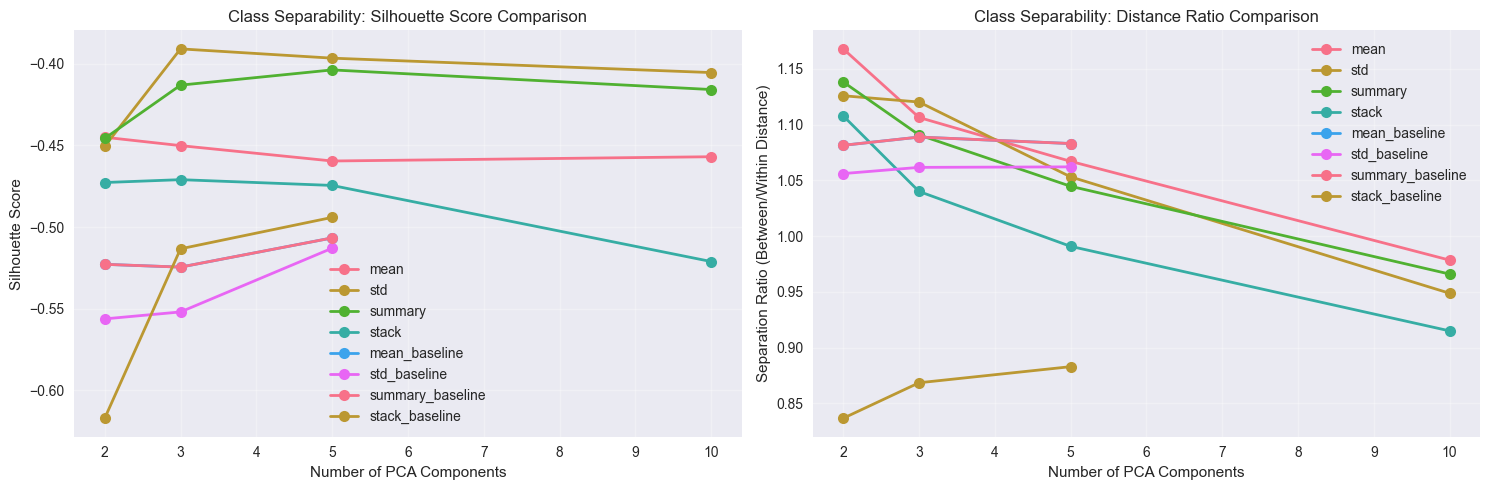

In [14]:
# Create summary comparison
comparison_data = []

for method_name, sep_results in separability_results.items():
    for n_comp, metrics in sep_results.items():
        comparison_data.append({
            'Method': method_name,
            'Components': n_comp,
            'Silhouette_Score': metrics['silhouette_score'],
            'Separation_Ratio': metrics['separation_ratio'],
            'Within_Class_Distance': metrics['avg_within_distance'],
            'Between_Class_Distance': metrics['avg_between_distance']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== Method Comparison Summary ===")
print(comparison_df.round(4))

# Find best methods for each metric
print("\n=== Best Performing Methods ===")
for n_comp in [2, 3, 5]:
    subset = comparison_df[comparison_df['Components'] == n_comp]
    if not subset.empty:
        best_silhouette = subset.loc[subset['Silhouette_Score'].idxmax()]
        best_separation = subset.loc[subset['Separation_Ratio'].idxmax()]
        
        print(f"\n{n_comp} Components:")
        print(f"  Best Silhouette Score: {best_silhouette['Method']} ({best_silhouette['Silhouette_Score']:.4f})")
        print(f"  Best Separation Ratio: {best_separation['Method']} ({best_separation['Separation_Ratio']:.4f})")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Silhouette scores
for method in comparison_df['Method'].unique():
    method_data = comparison_df[comparison_df['Method'] == method]
    filtered_data = method_data[method_data['Components'] < 20]
    axes[0].plot(filtered_data['Components'], filtered_data['Silhouette_Score'], 
                'o-', label=method, linewidth=2, markersize=8)

axes[0].set_xlabel('Number of PCA Components')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Class Separability: Silhouette Score Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Separation ratios
for method in comparison_df['Method'].unique():
    method_data = comparison_df[comparison_df['Method'] == method]
    filtered_data = method_data[method_data['Components'] < 20]
    axes[1].plot(filtered_data['Components'], filtered_data['Separation_Ratio'], 
                'o-', label=method, linewidth=2, markersize=8)

axes[1].set_xlabel('Number of PCA Components')
axes[1].set_ylabel('Separation Ratio (Between/Within Distance)')
axes[1].set_title('Class Separability: Distance Ratio Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights and Conclusions

Based on the PCA analysis of mel spectrogram features with different aggregation strategies:

In [15]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM PCA ANALYSIS OF MEL SPECTROGRAM FEATURES")
print("="*80)

# Find overall best method
avg_silhouette_by_method = comparison_df.groupby('Method')['Silhouette_Score'].mean()
best_overall_method = avg_silhouette_by_method.idxmax()
best_score = avg_silhouette_by_method.max()

print(f"\n1. BEST AGGREGATION METHOD:")
print(f"   - Overall best performer: {best_overall_method.upper()}")
print(f"   - Average silhouette score: {best_score:.4f}")

print(f"\n2. VARIANCE EXPLANATION:")
for method_name, result in pca_results.items():
    pca_model = result['pca_model']
    if pca_model is None:
        continue  # Skip baseline (no PCA) results
    var_2_comp = np.sum(pca_model.explained_variance_ratio_[:2])
    var_3_comp = np.sum(pca_model.explained_variance_ratio_[:3])
    print(f"   - {method_name.upper()}: 2 components = {var_2_comp:.3f}, 3 components = {var_3_comp:.3f}")

print(f"\n3. CLASS SEPARABILITY:")
best_2d = comparison_df[comparison_df['Components'] == 2].loc[comparison_df[comparison_df['Components'] == 2]['Silhouette_Score'].idxmax()]
best_3d = comparison_df[comparison_df['Components'] == 3].loc[comparison_df[comparison_df['Components'] == 3]['Silhouette_Score'].idxmax()]

print(f"   - Best 2D separation: {best_2d['Method']} (silhouette = {best_2d['Silhouette_Score']:.4f})")
print(f"   - Best 3D separation: {best_3d['Method']} (silhouette = {best_3d['Silhouette_Score']:.4f})")

print(f"\n4. FEATURE REDUNDANCY:")
redundancy_threshold = 0.95
for method_name, result in pca_results.items():
    pca_model = result['pca_model']
    if pca_model is None:
        continue  # Skip baseline (no PCA) results
    components_for_95_var = np.argmax(np.cumsum(pca_model.explained_variance_ratio_) >= redundancy_threshold) + 1
    total_features = aggregated_features[method_name].shape[1]
    redundancy_pct = (1 - components_for_95_var / total_features) * 100
    print(f"   - {method_name.upper()}: {components_for_95_var}/{total_features} components for 95% variance ({redundancy_pct:.1f}% redundancy)")

print(f"\n5. RECOMMENDATIONS:")
print(f"   - For class separation: Mel spectrogram in ESC-50 is NOT linearly separable")
print(f"   - Although 95% variance captured with very few PCA components, it does not improve class separability")
print(f"   - For 2D visualization: {best_2d['Method']} aggregation was the best")
print(f"   - For 3D visualization: {best_3d['Method']} aggregation was the best")

print(f"\n6. IDENTIFIED PATTERNS:")
if len(unique_classes) > 1:
    print(f"   - Analyzed {len(unique_classes)} ESC-50 classes: {', '.join(unique_classes)}")
    print(f"   - Mel spectrogram features are informative but NOT linearly separable (that's why silhouette gives low scores)")
    print(f"   - Mel spectrograms preserve spectral content, but class boundaries rely on non-linear manifold")
    print(f"   - Mel spectrogram features capture some meaningful class differences")

print("\n" + "="*80)
print("Analysis complete! Check the visualizations above for detailed class separation patterns.")
print("="*80)


KEY INSIGHTS FROM PCA ANALYSIS OF MEL SPECTROGRAM FEATURES

1. BEST AGGREGATION METHOD:
   - Overall best performer: STD
   - Average silhouette score: -0.4109

2. VARIANCE EXPLANATION:
   - MEAN: 2 components = 0.751, 3 components = 0.857
   - STD: 2 components = 0.751, 3 components = 0.804
   - SUMMARY: 2 components = 0.739, 3 components = 0.787
   - STACK: 2 components = 0.470, 3 components = 0.593

3. CLASS SEPARABILITY:
   - Best 2D separation: mean (silhouette = -0.4450)
   - Best 3D separation: std (silhouette = -0.3909)

4. FEATURE REDUNDANCY:
   - MEAN: 8/128 components for 95% variance (93.8% redundancy)
   - STD: 1/128 components for 95% variance (99.2% redundancy)
   - SUMMARY: 1/256 components for 95% variance (99.6% redundancy)
   - STACK: 1/27648 components for 95% variance (100.0% redundancy)

5. RECOMMENDATIONS:
   - For class separation: Mel spectrogram in ESC-50 is NOT linearly separable
   - Although 95% variance captured with very few PCA components, it does not i

## Future Analysis and Extensions

This analysis can be extended in several ways:

1. **Sample Size**: Increase/decrease `SAMPLES_PER_CLASS` and `MAX_CLASSES` for analysis
2. **Additional Features**: Combine mel spectrograms with MFCC, chroma, or other features
3. **Cross-Validation**: Ensure results generalize across different data splits
4. **LDA**: Evaluate LDA (Linear Discriminant Analysis) or deep features for class separability
5. **t-SNE**:  try t-SNE or UMAP to explore separability visually

## References

- ESC-50 Dataset: [Environmental Sound Classification](https://github.com/karolpiczak/ESC-50)
- AFX Library: [Audio Feature eXtraction toolkit](https://github.com/danilodsp/AFX)
- Principal Component Analysis: [Scikit-learn PCA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)